In [1]:
import numpy as np
import scipy as sp
from scipy.optimize import root

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = 16, 9
print plt.style

import fair
fair.__version__

<module 'matplotlib.style' from '/Users/OllieBraddy/anaconda/lib/python2.7/site-packages/matplotlib/style/__init__.pyc'>


'1.0.1'

In [2]:
# Define mean and varience of normal and log-normal distributions
mu_tcr, sigma_tcr = 0.45814, 0.27853
mu_rwf, sigma_rwf = 0.5818, 0.1

# Create points for TCR and RWF probablility density functions
x = np.arange(0.01,4.01,0.01)
TCR_pdf = (1 / (x*sigma_tcr*np.sqrt(2*np.pi))) * np.exp(-(((np.log(x)-mu_tcr)**2) / (2*sigma_tcr**2)))
RWF_pdf = (1 / (np.sqrt(2*np.pi*sigma_rwf**2))) * np.exp(-(((x-mu_rwf)**2)/(2*sigma_rwf**2)))

# Create array for cumulative distribution and define for TCR and RWF
CDF = np.arange(0.0,1.0,0.001)
TCR = np.exp(mu_tcr + (np.sqrt(2)*sigma_tcr*sp.special.erfinv((2*CDF) - 1)))
RWF = mu_rwf + (np.sqrt(2)*sigma_rwf*sp.special.erfinv((2*CDF) - 1))

# Define ECS at each cumulative distribution point
ECS = TCR / RWF

# Check for any infinities and set to zero
for i in range(0,CDF.shape[0]):
    if RWF[i] <= 0:
        RWF[i] = 0
        ECS[i] = 0

In [8]:
# 100 GtC pulse of carbon emmissions at year 20 and run for a further 200 years. Contribution from other radiative forcing is zero
emissions = np.zeros(220)
emissions[20] = 100.0
other_rf = np.zeros(emissions.size)

# Create a input parameter array which has a distribution of TCR and ECS as defined above, but all other parameters remain unchanged
input_params_in=np.array([0.33,0.41,1.6,2.75,239.0,4.1,0.2173,0.2240,0.2824,0.2763,1000000,394.4,36.54,4.304,32.40,0.019,4.165,3.74,278.0,2.123,97.0])

k = CDF.size
input_params = np.zeros([k,21])

for i in range(0,k):
    for j in range(0,21):
        input_params[i,j] = input_params_in[j]
        
input_params[...,2] = TCR
input_params[...,3] = ECS

import time
start_time = time.time()

C,T = fair.forward.fair_scm(emissions=emissions,
                                    other_rf=other_rf,
                                    input_params=input_params)

print("Run time was %s seconds" % round(((time.time() - start_time)),2))

Run time was 30.76 seconds


In [9]:
print C[0]

[ 278.          278.          278.          278.          278.          278.
  278.          278.          278.          278.          278.          278.
  278.          278.          278.          278.          278.          278.
  278.          278.          316.30772692  308.91553261  306.15418418
  304.38518887  303.00651587  301.87414566  300.92849463  300.13162161
  299.45498764  298.87609762  298.37696779  297.94313359  297.56291693
  297.22686196  296.92729382  296.65797031  296.41380526  296.19064778
  295.98510515  295.79440053  295.61625797  295.44880959  295.29052021
  295.14012626  294.99658604  294.85903928  294.72677414  294.59920035
  294.47582721  294.35624571  294.24011381  294.12714449  294.01709595
  293.90976355  293.80497325  293.70257622  293.60244442  293.50446702
  293.40854736  293.31460058  293.22255159  293.13233341  293.04388588
  292.95715449  292.8720895   292.78864517  292.70677917  292.62645204
  292.5476268   292.47026856  292.39434429  292.31982252  2

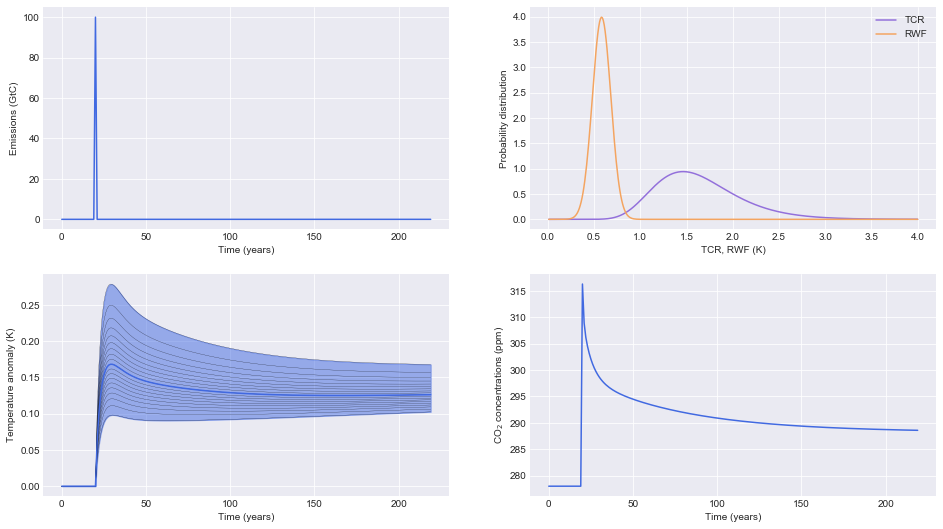

In [10]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.plot(range(0,emissions.size),emissions, color='royalblue')

ax2.plot(x, TCR_pdf, color='mediumpurple', label='TCR')
ax2.plot(x, RWF_pdf, color='sandybrown', label='RWF')

for y in range(1,20):
    ax3.plot(range(0,emissions.size),T[int(y*k/20)],color='black',linewidth=0.2)
ax3.plot(range(0,emissions.size),T[int(k/2)],color='royalblue',linewidth=1.5)
ax3.fill_between(range(0,220),
                     T[int(0.05*k)],
                     T[int(0.95*k)],
                     color='royalblue',
                     alpha=0.5)

ax4.plot(range(0,emissions.size),C[k/2], color='royalblue')

ax1.set_ylabel('Emissions (GtC)')
ax1.set_xlabel('Time (years)')
ax2.set_ylabel('Probability distribution')
ax2.set_xlabel('TCR, RWF (K)')
ax2.legend()
ax3.set_ylabel('Temperature anomaly (K)')
ax3.set_xlabel('Time (years)')
ax4.set_ylabel('CO$_2$ concentrations (ppm)')
ax4.set_xlabel('Time (years)')
#fig.savefig('Log-normal TCR test.pdf')